The notebook contains my deep dive into the data. All sections have detailed notes.

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
from scipy import stats

# Data Ingestion

In [5]:
%%time

ratings=pd.read_csv("title.ratings.tsv", sep="\t")
title_basics=pd.read_csv("title.basics.tsv", sep="\t")

CPU times: user 14.3 s, sys: 2.14 s, total: 16.4 s
Wall time: 16.9 s


# Exploratory Data Analysis

This section explores the general characteristics and patterns in data.

In [6]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1846
1,tt0000002,6.0,239
2,tt0000003,6.5,1612
3,tt0000004,6.0,155
4,tt0000005,6.2,2435


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202796 entries, 0 to 1202795
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1202796 non-null  object 
 1   averageRating  1202796 non-null  float64
 2   numVotes       1202796 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.5+ MB


In [8]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [9]:
title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8590684 entries, 0 to 8590683
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 589.9+ MB


In [10]:
%%time

ratings_combined=ratings.merge(title_basics, on="tconst", how="inner")
ratings_combined.head()

CPU times: user 8.46 s, sys: 1.31 s, total: 9.78 s
Wall time: 9.78 s


,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.7,1846,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,6.0,239,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,6.5,1612,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,6.0,155,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,6.2,2435,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [11]:
# verify the shape of data after merge
assert ratings.shape[0]==ratings_combined.shape[0]

In [12]:
# rename columns
ratings_combined.columns=['tconst', 'average_rating', 'num_votes', 'title_type', 
                                'primary_title', 'original_title', 'is_adult', 'start_year', 
                                'end_year', 'runtime_minutes', 'genres']

In [13]:
ratings_combined["title_type"].value_counts(dropna=False, normalize=True)

tvEpisode       0.479465
movie           0.227313
short           0.114930
tvSeries        0.066117
video           0.040495
tvMovie         0.040023
tvMiniSeries    0.010644
videoGame       0.010599
tvSpecial       0.008420
tvShort         0.001995
Name: title_type, dtype: float64

I will be using only `titleType="movie"` in this excercise. This is based on an assumption that the assignment is only asking for Movie rating prediction. In real world, if there is a problem statement for predicting ratings for all title_types (movie, tv_movie, short, tv_series etc), we may experiment with a variety of setups which solve our business problem in best possible way, e.g. one model for all title_types vs one separate model for all prominent title_types. 

In [14]:
ratings_movie=ratings_combined[ratings_combined.title_type=="movie"]

The description of the data clearly states that `endYear` is not available for `titleType` `movie`. So, I will drop the column.

In [15]:
ratings_movie.drop(["end_year"], axis="columns", inplace=True)

## Exploring the Genre

It seems like Drama, Comedy and Documentary are most popular genres. Last 9 genres collectively don't have 1000 occurences. While building the model, I would experiment and choose only most important genres. Also, I would have explored features from other csv files if I had more time in hand.

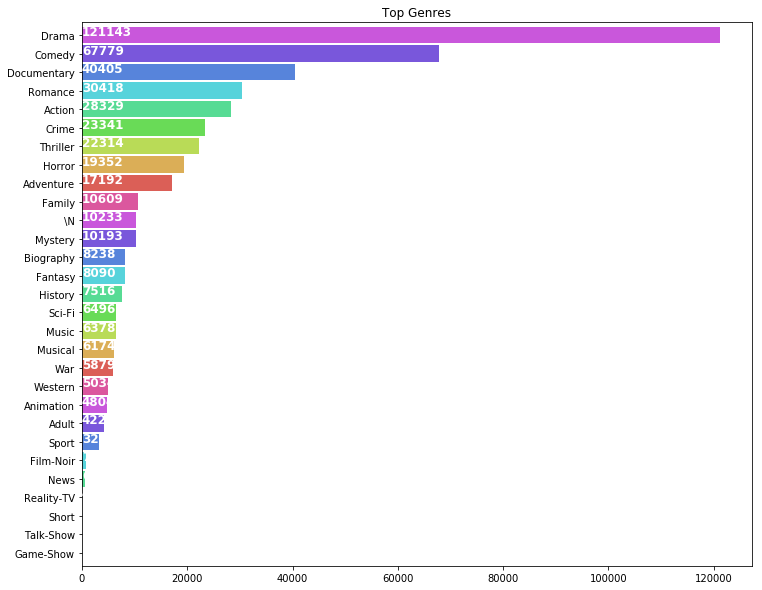

In [16]:
plt.subplots(figsize=(12,10))
genre_list = []
for i in ratings_movie['genres'].str.split(","):
    genre_list.extend(i)
ax = pd.Series(genre_list).value_counts().sort_values().plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(genre_list).value_counts().sort_values()): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

# Missing Values Analysis

In [17]:
ratings_movie.replace({"\\N":np.nan}).isnull().sum()

tconst                 0
average_rating         0
num_votes              0
title_type             0
primary_title          0
original_title         0
is_adult               0
start_year            28
runtime_minutes    27642
genres             10233
dtype: int64

In [18]:
ratings_movie.replace({"\\N":np.nan}, inplace=True)
ratings_movie.replace({None:np.nan}, inplace=True)
ratings_movie["is_adult"]=ratings_movie["is_adult"].astype(float).astype(str)
numeric_features=["average_rating", "num_votes", "start_year", "runtime_minutes"]
ratings_movie[numeric_features]=ratings_movie[numeric_features].astype(float)

# Outlier Analysis

The general practice for outlier analysis is to find out the datapoints which do not follow the general distribution and remove if they seem like an issue with the data. If a numeric feature values are outside 3 standard deviation from the mean, generally those values can be considered as outliers. However, how to treat the outliers is based on the business context always. We need to be extra cautious about removing such datapoints because they may represent important information within the data e.g. if you are building a fraud detection the outliers may be of interest. 

In the IMDB dataset, I saw outliers in a lot of columns but most of them seem like genuine datapoints. For instance, there is a movie which has runtime_minutes value as 51420 minutes which is 857 hours for a single movie. To my surprise, I found out from the IMDB website that this is an actual movie.
`num_votes`, `runtime_minutes` and the target `average_rating` do not follow normal distribution. While building linear models, we have to give special attention to these columns because they voilate the primary assumptions for building those models. However, tree-based models tend to handle outliers pretty well.

Business dictates a lot of times to remove some values which may seem somewhat arbitrary in our context. For instance, a movie which have only 5 votes with an average rating 10 is not necessarily better than a movie which 10000 votes and have average rating 9. There are ways to compensate for number of votes in such scenarios for example giving more weight to movies with higher average rating along with high number of votes. However, I will simply remove all movies having <10 votes (arbitrary cutoff). Often this cutoff is also experimented with in real world. 

In [19]:
# percentage of movies which are filtered outt
ratings_movie[ratings_movie.num_votes>10].shape[0]/ratings_movie.shape[0]

0.8781504767547758

In [20]:
ratings_movie=ratings_movie[ratings_movie.num_votes>10]

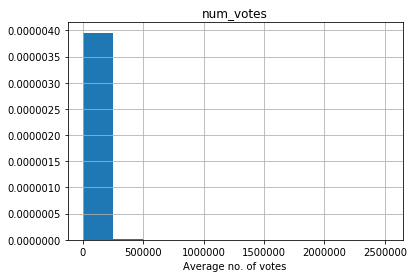

In [21]:
ratings_movie.hist(column=["num_votes"], density=True)
plt.xlabel('Average no. of votes')
plt.show()

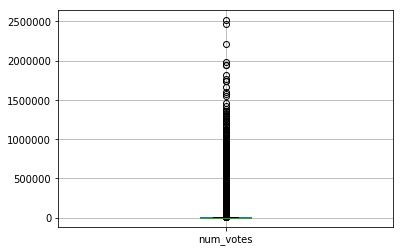

In [22]:
ratings_movie.boxplot(column=["num_votes"])

In [23]:
ratings_movie.num_votes.quantile(np.linspace(0.1,1,10))

0.1         15.0
0.2         22.0
0.3         32.0
0.4         49.0
0.5         80.0
0.6        137.0
0.7        261.0
0.8        594.0
0.9       2120.0
1.0    2520504.0
Name: num_votes, dtype: float64

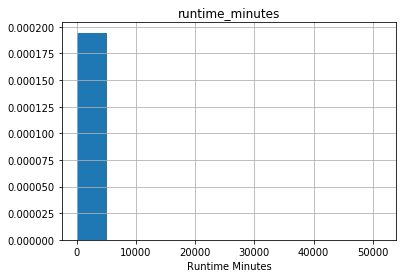

In [24]:
ratings_movie.hist(column=["runtime_minutes"], density=True)
plt.xlabel('Runtime Minutes')
plt.show()

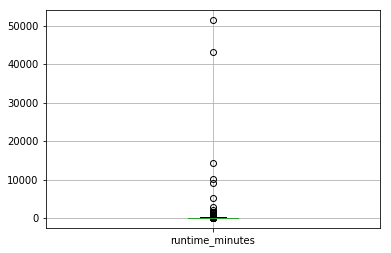

In [25]:
ratings_movie.boxplot(column=["runtime_minutes"])

Below code is only for demonstration purposes to show that we could have decided to remove values which fall outside 3 standard deviations from the mean.

In [26]:
ratings_movie[(np.abs(stats.zscore(ratings_movie["num_votes"])) > 3)].head()

,tconst,average_rating,num_votes,title_type,primary_title,original_title,is_adult,start_year,runtime_minutes,genres
3272,tt0012349,8.3,122086.0,movie,The Kid,The Kid,0.0,1921.0,68.0,"Comedy,Drama,Family"
4850,tt0017136,8.3,168970.0,movie,Metropolis,Metropolis,0.0,1927.0,153.0,"Drama,Sci-Fi"
7205,tt0021749,8.5,178517.0,movie,City Lights,City Lights,0.0,1931.0,87.0,"Comedy,Drama,Romance"
7457,tt0022100,8.3,152721.0,movie,M,M - Eine Stadt sucht einen Mörder,0.0,1931.0,117.0,"Crime,Mystery,Thriller"
11827,tt0027977,8.5,232377.0,movie,Modern Times,Modern Times,0.0,1936.0,87.0,"Comedy,Drama,Family"


In [27]:
ratings_movie[(np.abs((ratings_movie.runtime_minutes - ratings_movie.runtime_minutes.mean())/ratings_movie.runtime_minutes.std(ddof=0))>3)].head()


,tconst,average_rating,num_votes,title_type,primary_title,original_title,is_adult,start_year,runtime_minutes,genres
1437,tt0004052,7.0,108.0,movie,The Hazards of Helen,The Hazards of Helen,0.0,1914.0,1428.0,Action
51045,tt0074334,8.0,95.0,movie,Comment Yukong déplaça les montagnes,Comment Yukong déplaça les montagnes,0.0,1976.0,763.0,Documentary
64519,tt0090015,8.7,9155.0,movie,Shoah,Shoah,0.0,1985.0,566.0,"Documentary,History,War"
69664,tt0095979,7.5,107.0,movie,Resan,Resan,0.0,1987.0,873.0,"Documentary,War"
78767,tt0106772,7.5,58.0,movie,A Dream in Red Mansions,Hong lou meng,0.0,1988.0,735.0,Drama


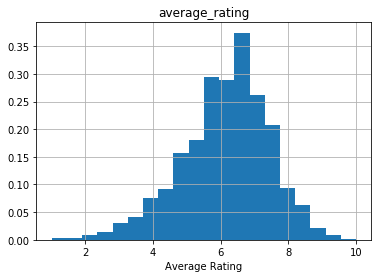

In [28]:
ratings_movie.hist(column=["average_rating"], density=True, bins=20)
plt.xlabel('Average Rating')
plt.show()

# Correlation Analysis

Correlation analysis is a great tool to identify relationships between dependent and independent variables. A higher correlation means that the variable in consideration can play a great role in predicting dependent variable values. The numeric features for this analysis below show that a strong correlation is lacking.

In [29]:
# Create new feature for years since release
current_year = datetime.datetime.now().year
ratings_movie["years_since_release"]=current_year-ratings_movie["start_year"]

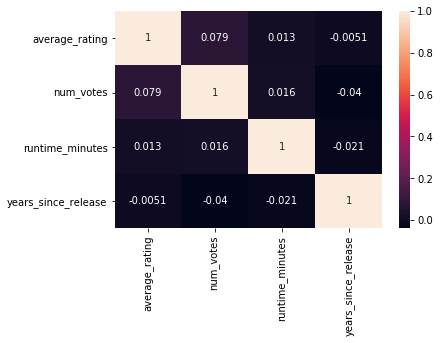

In [48]:
corr = ratings_movie.corr()

# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)